In [17]:
!pip install git+https://github.com/openai/whisper.git
!pip install git+https://github.com/PrithivirajDamodaran/Gramformer.git
!pip install transformers sentencepiece librosa soundfile pydub sentence-transformers
!apt install ffmpeg


  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-6k4cm9as
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-6k4cm9as
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/PrithivirajDamodaran/Gramformer.git to /tmp/pip-req-build-vzflnb2g
  Running command git clone --filter=blob:none --quiet https://github.com/PrithivirajDamodaran/Gramformer.git /tmp/pip-req-build-vzflnb2g
  Resolved https://github.com/PrithivirajDamodaran/Gramformer.git to commit 23425cd2e98a919384cab6156af8adf1c9d0639a
  Preparing metadata (setup.py) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded,

In [18]:
import os
from google.colab import files
from pydub import AudioSegment

# Create upload folder
upload_folder = "/content/wav_files"
os.makedirs(upload_folder, exist_ok=True)

# Upload files
uploaded = files.upload()
for filename in uploaded.keys():
    os.rename(filename, os.path.join(upload_folder, filename))


Saving Some days its really hard shorts depression sad.wav to Some days its really hard shorts depression sad.wav
Saving WhatsApp Audio 2025-04-16 at 23.49.56.wav to WhatsApp Audio 2025-04-16 at 23.49.56.wav
Saving ElevenLabs_2025-04-16T18_48_16_Rachel_pre_sp100_s50_sb75_se0_b_m2.wav to ElevenLabs_2025-04-16T18_48_16_Rachel_pre_sp100_s50_sb75_se0_b_m2.wav
Saving ElevenLabs_2025-04-16T18_51_18_Brian_pre_sp100_s50_sb75_se0_b_m2.wav to ElevenLabs_2025-04-16T18_51_18_Brian_pre_sp100_s50_sb75_se0_b_m2.wav
Saving stressed_male_voice.wav to stressed_male_voice.wav


In [19]:
def convert_all_to_wav(folder):
    for filename in os.listdir(folder):
        if not filename.endswith('.wav'):
            original_path = os.path.join(folder, filename)
            wav_path = os.path.join(folder, os.path.splitext(filename)[0] + '.wav')
            audio = AudioSegment.from_file(original_path)
            audio.export(wav_path, format="wav")
            os.remove(original_path)

convert_all_to_wav(upload_folder)


In [20]:
import numpy as np
import pandas as pd
import librosa
import whisper
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from gramformer import Gramformer

# Load models
whisper_model = whisper.load_model("base")
gf = Gramformer(models=1)
fill_mask = pipeline("fill-mask", model="bert-base-uncased")
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:897: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


[Gramformer] Grammar error correct/highlight model loaded..


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [21]:
# audio feature extraction
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    y_trimmed, _ = librosa.effects.trim(y)
    y_normalized = librosa.util.normalize(y_trimmed)

    duration = librosa.get_duration(y=y_normalized, sr=sr)
    f0, _, _ = librosa.pyin(y_normalized, fmin=50, fmax=500)
    pitch_mean = np.nanmean(f0)
    pitch_std = np.nanstd(f0)

    energy = librosa.feature.rms(y=y_normalized)[0]
    pause_frames = np.sum(energy < 0.01)
    pause_duration = pause_frames * 512 / sr

    onset_env = librosa.onset.onset_strength(y=y_normalized, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

    return {
        "duration_sec": duration,
        "mean_pitch": pitch_mean,
        "pitch_variability": pitch_std,
        "pause_duration": pause_duration,
        "speech_rate": tempo,
    }


In [22]:
# nlp feature extraction
negative_words = {"sad", "depressed", "unhappy", "lonely", "anxious", "afraid", "scared", "crying", "hopeless"}
hesitation_words = {"um", "uh", "erm", "hmm", "like"}

def count_negative_words(text):
    return sum(word in negative_words for word in text.lower().split())

def count_hesitations(text):
    return sum(word in hesitation_words for word in text.lower().split())

def detect_anomalies_with_bert(sentence):
    words = sentence.split()
    anomaly_count = 0
    for i, word in enumerate(words):
        masked = words.copy()
        masked[i] = "[MASK]"
        masked_sentence = " ".join(masked)
        predictions = fill_mask(masked_sentence)
        predicted_words = [pred["token_str"] for pred in predictions]
        if word.lower() not in predicted_words[:3]:
            anomaly_count += 1
    return anomaly_count

def sentence_completion_failure(sentence):
    words = sentence.split()
    if len(words) < 4:
        return 0
    index = np.random.randint(1, len(words) - 1)
    original_word = words[index]
    words[index] = "[MASK]"
    masked = " ".join(words)
    predictions = fill_mask(masked)
    top_preds = [p['token_str'].strip() for p in predictions]
    return 1 if original_word.lower() not in top_preds else 0

def count_grammar_issues(text):
    try:
        corrections = gf.detect(text)
        return len(corrections)
    except:
        return 0

def repetition_score(sentence):
    words = sentence.split()
    if len(words) < 2:
        return 0
    vectors = embedder.encode(words, convert_to_tensor=True)
    sim_matrix = util.pytorch_cos_sim(vectors, vectors)
    threshold = 0.8
    repetitions = (sim_matrix > threshold).sum().item()
    return repetitions / len(words)


In [23]:
def process_all_audio(folder_path):
    features_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder_path, filename)
            print(f"Processing: {filename}")

            audio_feat = extract_audio_features(file_path)
            result = whisper_model.transcribe(file_path)
            transcript = result["text"]

            record = {
                "file": filename,
                "transcript": transcript,
                "negative_word_count": count_negative_words(transcript),
                "hesitation_count": count_hesitations(transcript),
                "word_anomalies": detect_anomalies_with_bert(transcript),
                "lost_word_prediction": sentence_completion_failure(transcript),
                "grammar_issues": count_grammar_issues(transcript),
                "repetition_score": repetition_score(transcript),
            }

            record.update(audio_feat)
            features_list.append(record)

    return pd.DataFrame(features_list)

# Run the processor
df = process_all_audio(upload_folder)
df.head()


Processing: ElevenLabs_2025-04-16T18_51_18_Brian_pre_sp100_s50_sb75_se0_b_m2.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing: WhatsApp Audio 2025-04-16 at 23.49.56.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing: stressed_male_voice.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing: ElevenLabs_2025-04-16T18_48_16_Rachel_pre_sp100_s50_sb75_se0_b_m2.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing: Some days its really hard shorts depression sad.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


,file,transcript,negative_word_count,hesitation_count,word_anomalies,lost_word_prediction,grammar_issues,repetition_score,duration_sec,mean_pitch,pitch_variability,pause_duration,speech_rate
0,ElevenLabs_2025-04-16T18_51_18_Brian_pre_sp100...,"Hmm. Hey, I don't really know where to start....",0,4,38,0,0,3.782609,44.60800,153.001127,64.017927,12.224,[117.1875]
1,WhatsApp Audio 2025-04-16 at 23.49.56.wav,Days feel heavy. I tried to smile but it does...,0,1,21,0,0,2.607143,23.93600,323.636362,40.848012,0.000,[98.6842105263158]
2,stressed_male_voice.wav,"I, I don't know what to do. Everything's pili...",0,1,20,1,0,1.869565,18.14400,140.639260,13.597834,2.336,[156.25]
3,ElevenLabs_2025-04-16T18_48_16_Rachel_pre_sp10...,"Um, okay, I don't even know where to begin. E...",0,2,39,0,0,3.615385,28.73475,231.108416,19.558775,7.552,[133.92857142857142]
4,Some days its really hard shorts depression sa...,Some days it's really really hard to just mov...,0,0,8,0,0,2.333333,18.78400,235.104579,144.942812,0.960,[133.92857142857142]


In [24]:
df.to_csv("combined_audio_nlp_features.csv", index=False)

from google.colab import files
files.download("combined_audio_nlp_features.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
from sklearn.preprocessing import StandardScaler

# Select relevant features
selected_features = [
    "pause_duration",
    "hesitation_count",
    "negative_word_count",
    "grammar_issues",
    "word_anomalies",
    "lost_word_prediction",
    "repetition_score",
    "speech_rate",
    "pitch_variability"
]

# Fill missing values
X = df[selected_features].fillna(0)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [30]:
# using multiple machine learning models
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Features to use
selected_features = [
    "pause_duration",
    "hesitation_count",
    "negative_word_count",
    "grammar_issues",
    "word_anomalies",
    "lost_word_prediction",
    "repetition_score",
    "speech_rate",
    "pitch_variability"
]

X = df[selected_features].fillna(0)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------
# 1. Isolation Forest
# ----------------------
iso = IsolationForest(contamination=0.2, random_state=42)
# Fit the Isolation Forest model before using it
iso.fit(X_scaled) # This line is added to fit the model
df["iso_score"] = iso.decision_function(X_scaled) * -1

# ----------------------
# 2. One-Class SVM
# ----------------------
svm = OneClassSVM(nu=0.2, kernel="rbf", gamma='scale')
svm.fit(X_scaled)
df["svm_score"] = -svm.decision_function(X_scaled)

# ----------------------
# 3. Local Outlier Factor (LOF)
# ----------------------
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.2)
df["lof_score"] = -lof.fit_predict(X_scaled)  # Returns -1 for outlier, 1 for inlier
df["lof_score"] = np.where(df["lof_score"] == -1, 1.0, 0.0)  # 1 = outlier, 0 = normal

# ----------------------
# 4. KMeans Distance from Centroid
# ----------------------
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)
df["kmeans_score"] = distances

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:282: UserWarning: n_neighbors (10) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


In [31]:
# Combine scores (normalize individually first)
scores = ["iso_score", "svm_score", "lof_score", "kmeans_score"]
df[scores] = MinMaxScaler().fit_transform(df[scores])

# Average score
df["risk_score_raw"] = df[scores].mean(axis=1)
df["risk_percent"] = df["risk_score_raw"] * 100

# Flag high risk (threshold > 70%)
df["high_risk_flag"] = df["risk_percent"] > 70


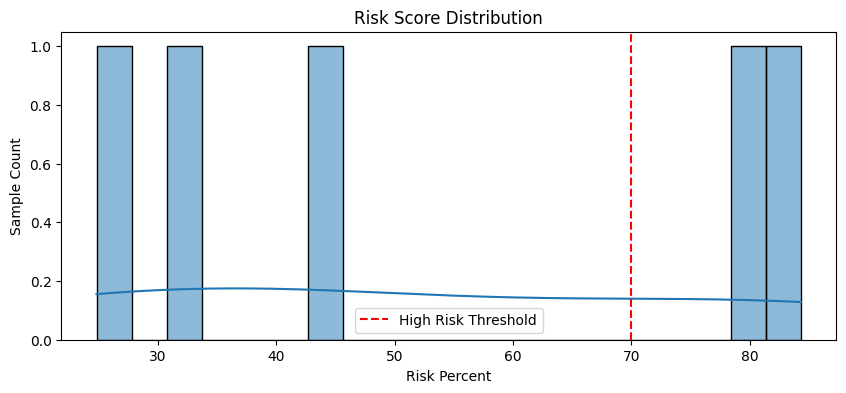

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.histplot(df["risk_percent"], bins=20, kde=True)
plt.axvline(70, color='red', linestyle='--', label='High Risk Threshold')
plt.title("Risk Score Distribution")
plt.xlabel("Risk Percent")
plt.ylabel("Sample Count")
plt.legend()
plt.show()


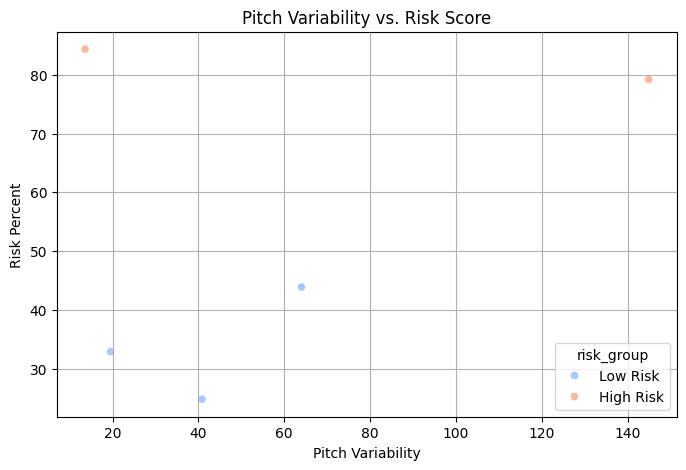

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... (your existing code) ...

# Create 'risk_group' column based on 'high_risk_flag'
df['risk_group'] = df['high_risk_flag'].map({True: 'High Risk', False: 'Low Risk'})

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="pitch_variability", y="risk_percent", hue="risk_group", palette="coolwarm")
plt.title("Pitch Variability vs. Risk Score")
plt.xlabel("Pitch Variability")
plt.ylabel("Risk Percent")
plt.grid(True)
plt.show()